# Load packages

In [43]:
from __future__ import print_function, division 
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np
from datetime import date
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

SavePlots = False

# Data

### Loading and splitting data

In [63]:
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

remove non-essential rows, columns and Nan

In [64]:
data['Date'] = pd.to_datetime(data['Date'])
data1 = data[data['Date'] >= '1985-01-02']

col_to_keep = ['Date']
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]
all_keep_cols = col_to_keep + sveny_cols
data2 = data1[all_keep_cols]
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

plot_data =data2
plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)
plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

data = plot_data.dropna()
data['Date'] = pd.to_datetime(data['Date']).dt.date

train = data[data['Date'] >= date(1985, 1, 2)]
train = train[train['Date'] <= date(2017, 12, 31)] 

valid = data[data['Date'] >= date(2018, 1, 1)] 
valid = valid[valid['Date'] <= date(2024, 12, 31)] 

test = data[data['Date'] >= date(2025, 1, 1)] 

/var/folders/0z/k0qzkdjj4rd_2_dy9slhrrkh0000gn/T/ipykernel_43871/1234211664.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']).dt.date


___

### Data overview

Histogram of yield 2 and 20

In [52]:
def plot_histogram(column_name, bins=30):
    if column_name not in plot_data.columns:
        print(f"Column '{column_name}' not found in data.")
        return

    plt.figure(figsize=(6, 4))
    plt.hist(plot_data[column_name].dropna(), bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_histogram('2')
plot_histogram('10', bins=20) 


Column '2' not found in data.
Column '10' not found in data.


3D plot of all type of yields

/var/folders/0z/k0qzkdjj4rd_2_dy9slhrrkh0000gn/T/ipykernel_43871/3572421373.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


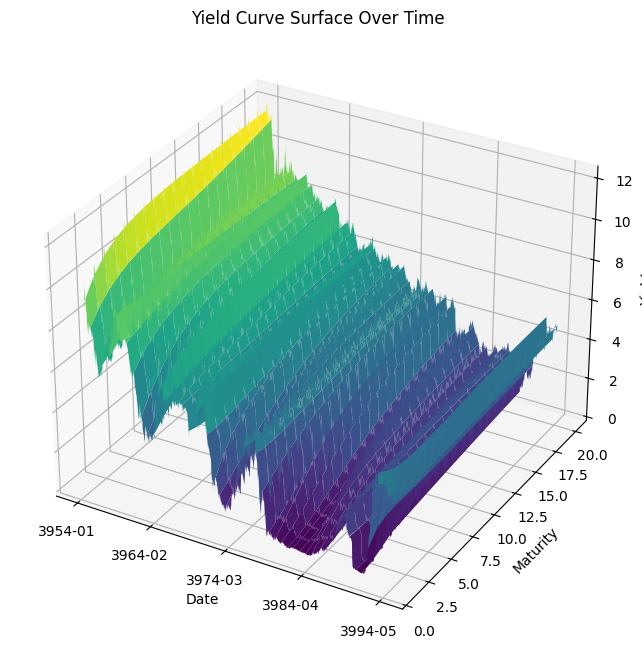

In [41]:
X = plot_data['Date'].map(pd.Timestamp.toordinal).values

maturity_cols = sorted([col for col in plot_data.columns if col.isdigit()], key=lambda x: int(x))
Y = np.array([int(m) for m in maturity_cols]) 

Z = plot_data[maturity_cols].values

X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis')

ax.set_xlabel('Date')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_title('Yield Curve Surface Over Time')

from matplotlib.dates import num2date
ax.set_xticks(np.linspace(X.min(), X.max(), 5))
ax.set_xticklabels([num2date(t).strftime('%Y-%m') for t in np.linspace(X.min(), X.max(), 5)])

plt.tight_layout()
plt.show()

Plot of all data of yield type 2 and 20

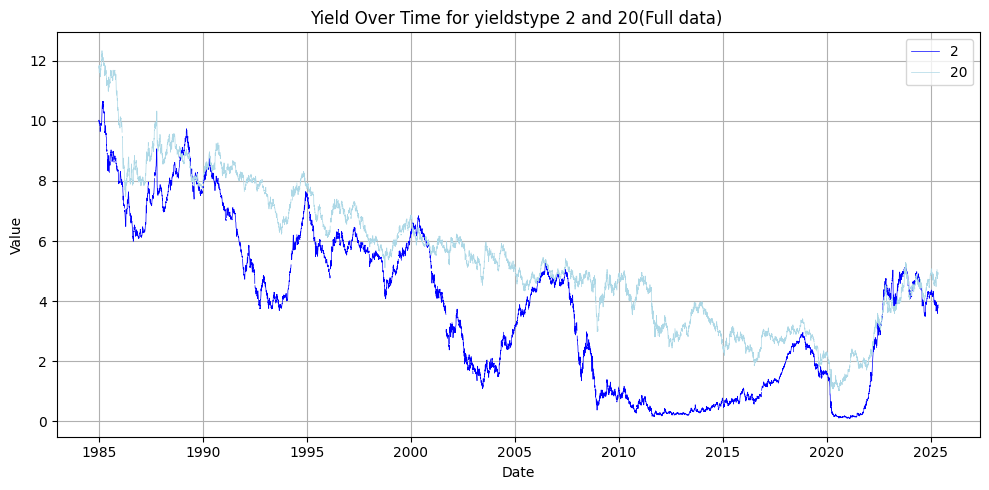

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(plot_data['Date'], plot_data['2'], label='2', color='blue', linewidth=0.5)
plt.plot(plot_data['Date'], plot_data['20'], label='20', color='lightblue', linewidth=0.5)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Yield Over Time for yieldstype 2 and 20 (Full data)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Predicting yields

## Baseline

## GRU 

### Yield type 2

makeing the model

In [66]:
maturity_col = '2'
time_step = 20
future_days = 1

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === GRU model ===
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)

Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


___

Predict

In [ ]:

predicted_scaled = model.predict(X_test)
true_scaled = y_test

predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
true = scaler.inverse_transform(true_scaled.reshape(-1, 1))


aligned_test_dates = test['Date'].values[-len(y_test):]
expected_len = len(y_test)
aligned_test_dates = test['Date'].values[-expected_len:]

predicted = predicted.flatten()
true = true.flatten()

Plot predictions

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_dates, true, label='True', color='blue')
plt.plot(aligned_test_dates, predicted, label='Predicted', color = 'lightblue')
plt.title(f"Predicted yield for type 2\nMSE = {mean_squared_error(true_all, predicted_all):.6f}")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Yield type 20

making the model

In [65]:
maturity_col = '20'
time_step = 20
future_days = 1

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === GRU model ===
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)

Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


## XGBoost